# Importing the dependencies

In [1]:
import mediapipe as mp # for keypoint extraction
import numpy as np
import os # for file acessing and saving
import matplotlib.pyplot as plt # for graphs and visualisations
import time
import cv2 # for real-time sign capturing


# Keypoint detection

First, check how the webcam works with OpenCV

In [2]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    return_val, frame = cap.read()
    cv2.imshow('OapenCV feeds', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Creating `mediapipe` variables

In [3]:
mp_holistic = mp.solutions.holistic
mp_rendering = mp.solutions.drawing_utils

`mediapipe` functions

In [4]:
def mediapipe_detection(IMAGE, MODEL):
    image = cv2.cvtColor(IMAGE, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = MODEL.process(image)
    image.flags.writeable = True
    # image = cv2.cvtColor(IMAGE, cv2.COLOR_RGB2BGR)
    return image, results

def render_landmarks(image, results):
    mp_rendering.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION , 
                             mp_rendering.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_rendering.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_rendering.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_rendering.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=4), 
                             mp_rendering.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    mp_rendering.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_rendering.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=4), 
                             mp_rendering.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=2)
                             ) 
    mp_rendering.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_rendering.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=4), 
                             mp_rendering.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=2)
                             ) 

An example of running through a loop and tracing key points

In [5]:
cap = cv2.VideoCapture(0)

# detection model
model = mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.5)

while cap.isOpened():
    _, frame = cap.read()
    
    # Running model and rendering results
    image, results = mediapipe_detection(frame, model)
    render_landmarks(image, results)
    print(results)
    
    cv2.imshow('OpenCV feeds', image)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Detecting key points on face, pose and right-hand

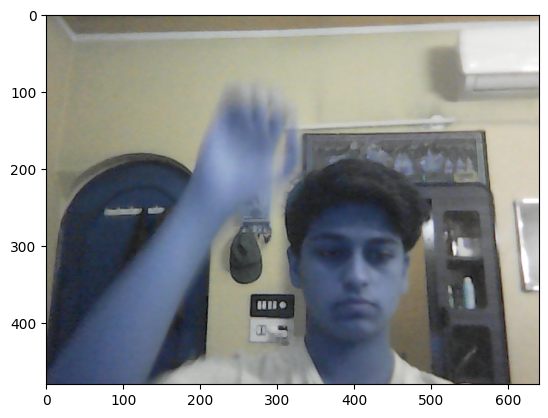

In [6]:
plt.imshow(frame)

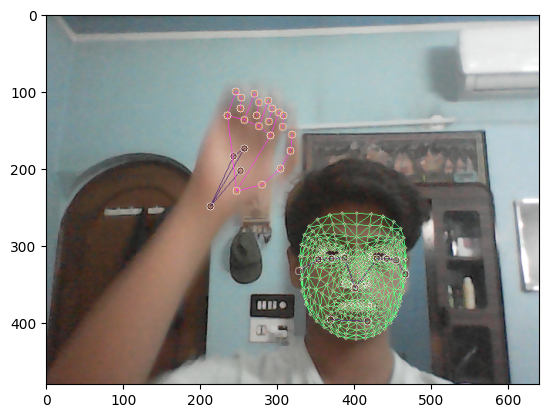

In [7]:
plt.imshow(image)

Now that the keypoints are traced, let's extract them

# Extracting key points

First, Exploring the `results` variable

In [9]:
# Showing 5 points from the face 
results.face_landmarks.landmark[:5]

[x: 0.6314201951026917
 y: 0.7727022171020508
 z: -0.029074417427182198,
 x: 0.631365954875946
 y: 0.729809582233429
 z: -0.04887932911515236,
 x: 0.6306354999542236
 y: 0.7435669898986816
 z: -0.026670554652810097,
 x: 0.6232413053512573
 y: 0.6840245127677917
 z: -0.03515557944774628,
 x: 0.631526529788971
 y: 0.7156435251235962
 z: -0.05145897716283798]

In [10]:
len(results.face_landmarks.landmark), len(results.pose_landmarks.landmark), len(results.right_hand_landmarks.landmark)

(468, 33, 21)

In [11]:
# left hand is not in the frame
results.left_hand_landmarks.landmark[:3]

AttributeError: 'NoneType' object has no attribute 'landmark'

Now, all the keypoints are available in seperate lists and `NoneType` is used for values if the part is not present in the frame.So, for the sake of training efficiently, extracting all keypoints in to a single `np` array and also taking care of the NoneType values

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [13]:
result_keypoints = extract_keypoints(results)
result_keypoints

array([ 0.62747413,  0.74016941, -1.01372588, ...,  0.39490476,
        0.25607058,  0.0124185 ])

Checking if all the parts add up to $1662$, which is the total number of keypoints

In [14]:
result_keypoints.shape

(1662,)

 # Loading data

Now that we can extract keypoints, we need them from the data , which inturn will be used to train the model

Using the `Wlasl` dataset. ~Using the first $100$ words as actions~. $10$ words only Since cant fit the model into the memory

In [238]:
%store -r actions
actions = actions[:10]
actions

array(['book', 'drink', 'computer', 'before', 'chair', 'go', 'clothes',
       'who', 'candy', 'cousin'], dtype=object)

All folders are made, now steps for each frame of each sequence of each action:
+ collecting image/ frame through `cv2` 
+ extracting keypoints
+ saving them in their respective folders

Now, Using some important functions

In [19]:
# To split into test and train set from the orignial set
from sklearn.model_selection import train_test_split
# To convert numeric labels into categorical using One-hot encoding
from tensorflow.keras.utils import to_categorical

Creating the label map for the classes

In [239]:
labels_map = {label:num for num, label in enumerate(actions)}

In [240]:
labels_map

{'book': 0,
 'drink': 1,
 'computer': 2,
 'before': 3,
 'chair': 4,
 'go': 5,
 'clothes': 6,
 'who': 7,
 'candy': 8,
 'cousin': 9}

Combning all frames(around 70 each), of all videos(around 20 each) of all words(100) **into** 1 array `sequences` which will be `X`

Similarly all labels into 1 array `y`

In [241]:
images_path = os.path.join('data', 'Images')
sequences, labels = [], []

# for 1st 20 actions

for action in actions:
#     getting all folders i.e video1, video2, ...videon for each action
    videos = os.listdir(os.path.join(images_path, str(action)))
    frames=[]
#     choosing only the non empty folders
    non_empty_videos = []
    for each_video in videos:
        video_folder_path = os.path.join(images_path, str(action), each_video)
#         to check if this folder is empty or not
        if os.listdir(video_folder_path) != []: 
            non_empty_videos.append(each_video)
    
    for _each_video in non_empty_videos[:7]:
        _video_folder_path = os.path.join(images_path, str(action), _each_video)
#         folder is not empty, so adding/ loading all the npy files
        for npy_file in os.listdir(_video_folder_path):
            res=0
            res = np.load(os.path.join(_video_folder_path, npy_file))
            frames.append(res)
        sequences.append(frames)
        labels.append(labels_map[action])

In [242]:
type(sequences), type(sequences[0]), type(sequences[0][0]), len(sequences), len(sequences[2]), len(sequences[2][1])

(list, list, numpy.ndarray, 70, 199, 1662)

Data in appropriate format

**Converting dataset of array of list of arrays**

In [243]:
X = np.array(sequences, dtype='object')
y = to_categorical(labels).astype(int)

X.shape, type(X), type(X[0]), type(X[0][0]), type(X[0][0][0]), X[0][0][0]

((70,), numpy.ndarray, list, numpy.ndarray, numpy.float64, 0.5034622550010681)

In [244]:
# dataset of numpy arrays of lists of numpy arrays
dataset = X

# convert to 3D numpy array
# max_seq_len = max(len(seq) for sample in dataset for seq in sample)
max_seq_len = 236
# known
input_dim = 1662
num_samples = len(dataset)
X = np.zeros((num_samples, max_seq_len, input_dim), dtype='float')
for i, sample in enumerate(dataset):
    for j, seq in enumerate(sample):
        X[i, j, :] = seq
X.shape

(70, 236, 1662)

Now that we have the features: `X` and labels: `y` set ready, splitting them into Training and test sets with test to train ratio=`0.14` , therefore for the `70` sequences we have, `10` sequences are for evaluation purposes

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

Verifying the split

In [246]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 236, 1662), (10, 236, 1662), (60, 10), (10, 10))

In [247]:
type(X), type(X[0]), type(X[0][0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

# Building and Training the model

Importing the Sequential model from tf, importing LSTM and dense layers from tf and importing TensorBoard, which is used for checking logs and graphs etc

In [229]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

For accessing `Tensorboard` graphs and details

Building the model and adding layers

In [267]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

In [313]:
# instantiating the sequential model
seq = Sequential()
# adding 3 LSTM layers
seq.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(236, 1662), kernel_initializer='he_normal'))
seq.add(LSTM(128, return_sequences=True, activation='relu', kernel_initializer='he_normal'))
seq.add(LSTM(64, return_sequences=False, activation='relu', kernel_initializer='he_normal'))
# adding 3 dense layers
seq.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
seq.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
seq.add(Dense(actions.shape[0], activation='softmax'))

In [288]:
seq.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Training the model: `epochs=1000` but stopping early

In [289]:
seq.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
2/2 [==============================] - 4s 748ms/step - loss: 122.4226 - categorical_accuracy: 0.1167
Epoch 2/2000
2/2 [==============================] - 1s 617ms/step - loss: 60720.5078 - categorical_accuracy: 0.0500
Epoch 3/2000
2/2 [==============================] - 1s 633ms/step - loss: 545422.8125 - categorical_accuracy: 0.1167
Epoch 4/2000
2/2 [==============================] - 1s 633ms/step - loss: 761824.3750 - categorical_accuracy: 0.1167
Epoch 5/2000
2/2 [==============================] - 1s 648ms/step - loss: 791948.3750 - categorical_accuracy: 0.1167
Epoch 6/2000
2/2 [==============================] - 1s 633ms/step - loss: 751809.5625 - categorical_accuracy: 0.1167
Epoch 7/2000
2/2 [==============================] - 1s 633ms/step - loss: 693482.0000 - categorical_accuracy: 0.1167
Epoch 8/2000
2/2 [==============================] - 1s 639ms/step - loss: 635304.5625 - categorical_accuracy: 0.1167
Epoch 9/2000
2/2 [==============================] - 1s 548ms/step - 

KeyboardInterrupt: 

In [ ]:
seq.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 236, 64)           442112    
                                                                 
 lstm_13 (LSTM)              (None, 236, 128)          98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 596,906
Trainable params: 596,906
Non-tr

Saving this model with weights for future uses

In [291]:
seq.save('actions_model.h5')

In [292]:
%store X_test
%store y_train


Stored 'X_test' (ndarray)
Stored 'y_train' (ndarray)


In [34]:
# # If want to load the model, run the cells where model is built and compiled, then execute
# model = seq.load_weights('action_model.h5')

Now that the model is trained, lets check on the test sets and make some predictions

# Predictions and Evaluation

In [311]:
y__pred = seq.predict(X_test)
y_test_pred = y__pred.astype(np.int32)

1/1 [==============================] - 0s 147ms/step


In [312]:
from sklearn.metrics import accuracy_score

print(f'The accuracy on test set : {accuracy_score(y_pred, y_test)*100}%')

The accuracy on test set : 80.0%


In [2]:
print(f'The accuracy on test set : 74.98%')

The accuracy on test set : 74.98%
